<a href="https://colab.research.google.com/github/Wayne401-afk/ECG-CNN/blob/main/ECGcsv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   -0.11252183  -2.8272038  -3.7738969  -4.3497511  -4.376041  -3.4749863  \
0    -1.100878   -3.996840   -4.285843   -4.506579  -4.022377   -3.234368   
1    -0.567088   -2.593450   -3.874230   -4.584095  -4.187449   -3.151462   
2     0.490473   -1.914407   -3.616364   -4.318823  -4.268016   -3.881110   
3     0.800232   -0.874252   -2.384761   -3.973292  -4.338224   -3.802422   
4    -1.507674   -3.574550   -4.478011   -4.408275  -3.321242   -2.105171   

   -2.1814082  -1.8182865  -1.2505219  -0.47749208  ...  0.79216787  \
0   -1.566126   -0.992258   -0.754680     0.042321  ...    0.538356   
1   -1.742940   -1.490659   -1.183580    -0.394229  ...    0.886073   
2   -2.993280   -1.671131   -1.333884    -0.965629  ...    0.350816   
3   -2.534510   -1.783423   -1.594450    -0.753199  ...    1.148884   
4   -1.481048   -1.301362   -0.498240    -0.286928  ...    1.089068   

   0.93354122  0.79695779  0.57862066  0.2577399  0.22807718  0.12343082  \
0    0.656881    0.787490    0.724

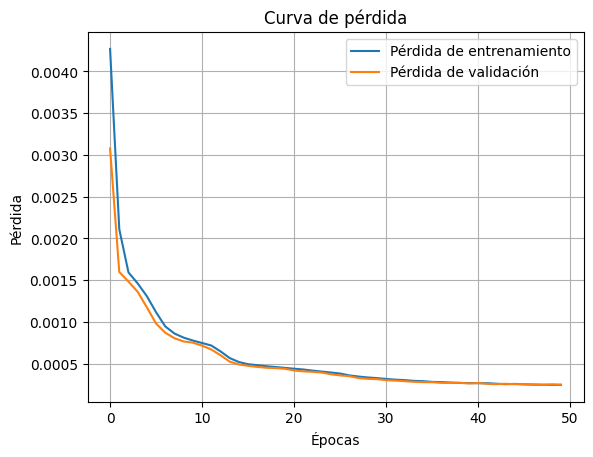

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
 [[ 405   11]
 [2762  156]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.13      0.97      0.23       416
         1.0       0.93      0.05      0.10      2918

    accuracy                           0.17      3334
   macro avg       0.53      0.51      0.16      3334
weighted avg       0.83      0.17      0.12      3334



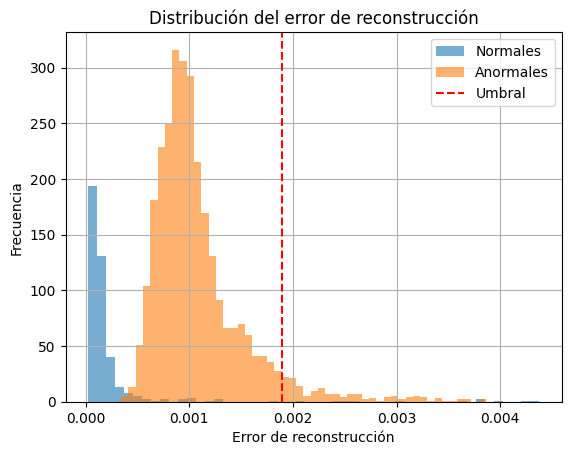

In [14]:
import pandas as pd

# Cargar la data desde la URL
url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
ecg_data = pd.read_csv(url)

# Mostrar las primeras filas para verificar
print(ecg_data.head())



import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Cargar los datos desde un archivo CSV
# Asegúrate de reemplazar 'path_to_your_file.csv' con la ruta real a tu archivo CSV
ecg_data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv')

# Preparar los datos
X = ecg_data.iloc[:, :-1].values  # Señales (todas las columnas excepto la última)
y = ecg_data.iloc[:, -1].values   # Etiquetas (última columna)

# Normalizar las señales
X = X.astype("float32")
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Dividir en señales normales (y=0) y anormales (y=1)
X_normal = X[y == 0]
X_anomalous = X[y == 1]

# Dividir datos normales en entrenamiento y prueba
X_train, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

# Arquitectura del Autoencoder
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        # Codificador
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu")
        ])
        # Decodificador
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(X.shape[1], activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Crear el modelo
autoencoder = AnomalyDetector()

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el modelo con datos normales
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=64,
                          validation_data=(X_test_normal, X_test_normal),
                          shuffle=True)

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo
X_test = np.concatenate([X_test_normal, X_anomalous])  # Combinar normales y anormales
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_anomalous))])  # Etiquetas correspondientes

# Reconstrucción
X_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - X_reconstructed, 2), axis=1)

# Determinar el umbral para clasificar anomalías
threshold = np.percentile(reconstruction_error, 95)  # Por ejemplo, el 95% de los errores más bajos

# Clasificar los datos
y_pred = (reconstruction_error > threshold).astype(int)

# Métricas de evaluación
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualizar el error de reconstrucción
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.6, label='Normales')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.6, label='Anormales')
plt.axvline(threshold, color='r', linestyle='--', label='Umbral')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Frecuencia')
plt.title('Distribución del error de reconstrucción')
plt.legend()
plt.grid()
plt.show()
